In [31]:
# For Aston_Martin

from datetime import datetime
import pandas as pd
import re
import numpy as np

# Current year for the 'Brand New' cars
current_year = datetime.now().year

# Load the data
file_path = 'cleaned_auto_trader_data_aston_martin.csv' # Has to be the cleaned data as this is file that's updated
data = pd.read_csv(file_path)

# Function to extract numeric part from a string (for 'Price' and 'Mileage')
def extract_numeric(value):
    try:
        # Remove non-digit characters, preserve decimal points and negative signs
        numeric_string = re.sub("[^-0-9.]", "", str(value))
        return float(numeric_string)
    except ValueError:
        return np.nan  # Return NaN for non-numeric or empty values
    
    

# Clean the 'Year' column by removing parentheses and their contents
data['Year'] = data['Year'].astype(str).apply(lambda x: re.sub(r'\s*\(.*\)', '', x)).astype(float)

# Apply transformations and validations
data['Price'] = data['Price'].apply(extract_numeric)
data['Mileage'] = data['Mileage'].apply(extract_numeric)
data['Prior_Owners'] = data['Prior_Owners'].apply(extract_numeric)  # Updated to use extract_numeric

# Fill in missing data with 'Unknown' only for Engine_Size column
data['Engine_Size'] = data['Engine_Size'].fillna('Unknown')

print("BEFORE FILTER:",len(data))
# ! filter by price remove high value vehicles
# data = data[data['Price'] <= 150000]
print("AFTER FILTER:",len(data))

# Fill in missing data with 'Unknown' for other categorical columns
categorical_columns = ['Model', 'Additional_Comments', 'Car_Type', 'Engine_Type', 'Dealership_Location', 'Sale_Type']
data[categorical_columns] = data[categorical_columns].fillna('Unknown')

# Remove rows with 'Unknown' values in critical columns
data = data[data['Price'] != 'Unknown']
data = data[data['Mileage'] != 'Unknown']
data = data[data['Year'] != 'Unknown']

# Adding the delete duplicates feature
cleaned_data = data.drop_duplicates()

# Save the cleaned data to a new file
cleaned_file_path = 'filtered_cleaned_auto_trader_data_aston_martin.csv'
data.to_csv(cleaned_file_path, index=False)

BEFORE FILTER: 1049
AFTER FILTER: 1049


In [32]:
# EXPLORATORY DATA ANALYSIS

import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
print("Loading data...")
file_path = 'cleaned_auto_trader_data_aston_martin.csv'
data = pd.read_csv(file_path)

# Preprocess numeric columns
print("Preprocessing numeric columns...")
for col in ['Price', 'Mileage', 'Year', 'Prior_Owners']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    # data[col].fillna(data[col].mean(), inplace=True)

# Filter the data
filtered_data = data[data['Price'] <= 0.25*1e6]

# Create the pair plot
numeric_features_to_plot = ['Mileage', 'Year', 'Prior_Owners', 'Price']
# plt.figure(figsize=(12,12))
# sns.pairplot(filtered_data[numeric_features_to_plot])


Loading data...
Preprocessing numeric columns...


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame and 'price' is the column with car prices

# Basic Statistics
print("Basic Statistics:")
print(data['Price'].describe())

# # Histogram
# plt.figure(figsize=(10, 6))
# plt.hist(data['Price'], bins=30, edgecolor='black')
# plt.title('Histogram of Car Prices')
# plt.xlabel('Price')
# plt.ylabel('Frequency')
# plt.show()


Basic Statistics:
count    1.049000e+03
mean     9.985700e+04
std      1.392365e+05
min      1.599500e+04
25%      4.250000e+04
50%      7.495000e+04
75%      1.199000e+05
max      2.760000e+06
Name: Price, dtype: float64


In [34]:
# For Aston_Martin - Extended Data

from datetime import datetime
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import joblib

# Load the data
print("Loading data...")
file_path = 'filtered_cleaned_auto_trader_data_aston_martin.csv'
data = pd.read_csv(file_path)

# Preprocess numeric columns
print("Preprocessing numeric columns...")
for col in ['Price', 'Mileage', 'Year', 'Prior_Owners']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col].fillna(data[col].mean(), inplace=True)

# Preprocessing pipelines
print("Creating preprocessing pipelines...") # TODO visualise the data after and before preprocessing to see if any issues with it
numeric_features = ['Mileage', 'Year', 'Prior_Owners']
numeric_transformer = StandardScaler()

categorical_features = ['Make', 'Car_Type', 'Sale_Type']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# TF-IDF Vectorizer for 'Model' column
print("Applying TF-IDF Vectorization...") # TODO check results of this vectorisation. not sure TF-IDF is needed for "Model" of car tbh but interesting.
tfidf_vectorizer = TfidfVectorizer(max_features=2500)
X_tfidf = tfidf_vectorizer.fit_transform(data['Model'])

# Fit and transform the data using the preprocessor
X_preprocessed = preprocessor.fit_transform(data.drop('Model', axis=1)) # TODO check the data here is not a concatination, but just the preprocessed data 

# Combine TF-IDF features with preprocessed numeric and categorical features # TODO investigate how this data looks, both TFIDF and preprocessed, to see if we really can expect model to fit to both at same time
X_combined = np.hstack((X_tfidf.toarray(), X_preprocessed if isinstance(X_preprocessed, np.ndarray) else X_preprocessed.toarray()))
# TODO I think bunching this data together and using random forest isn't a good combination. Need to visualise both the TFIDF data and preprocessed data, seperately, and both before and after preprocessing. Do some exploratory data analysis. Visualise words with word map (bigger words for more frequent) and visualise numeric data with grid map different variables on each axis of grid

# Split the data
print("Splitting data...")
y = data['Price'].values
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# TODO try and get random forest to show which features it is weighting (importances)

# Model Training with Hyperparameter Tuning
print("Training model with hyperparameter tuning...")
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Use the best estimator # TODO investigate the "performance" of each model with different hyperparamter tuning. Check it's actually finding a good one, not just the least poor performing.
best_model = grid_search.best_estimator_
print("Best model found:", best_model)

# Predictions and Evaluation
print("Making predictions and evaluating...")
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

# Output the model performance
print(f'MSE: {mse}')
print(f'MAE: {mae}')  
print(f'R2 Score: {r2}') # TODO this score seems good. but not great. Investigate examples where it's accurate, and where it's messing up. see if there's anything obvious. back to EDA


# Save the model, vectorizer, and preprocessor
print("Saving model, vectorizer, and preprocessor...")
joblib.dump(best_model, 'car_price_prediction_model_aston_martin.joblib')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_aston_martin.joblib')
joblib.dump(preprocessor, 'preprocessor_aston_martin.joblib')

print("Process completed.")

Loading data...
Preprocessing numeric columns...
Creating preprocessing pipelines...
Applying TF-IDF Vectorization...
Splitting data...
Training model with hyperparameter tuning...


In [ ]:
# y_test_filtered = y_test.copy()
# y_pred_filtered = y_pred.copy()

In [ ]:
# DIVING INTO INFERENCE ACCURACY

# Analyze performance in different price categories
price_categories = [(0, 100000), (100000, 200000), (200000, 300000), 
                    (300000, 400000), (400000, 500000), (500000, 600000), 
                    (600000, 700000), (700000, 800000), (800000, 900000), 
                    (900000, 1000000), (1000000, np.inf)]

for lower, upper in price_categories:
    mask = (y_test >= lower) & (y_test < upper)
    y_test_segment = y_test[mask]
    y_pred_segment = y_pred[mask]

    if len(y_test_segment) > 0:
        mse_segment = mean_squared_error(y_test_segment, y_pred_segment)
        mae_segment = mean_absolute_error(y_test_segment, y_pred_segment)

        print(f"Price Range {lower}-{upper if upper != np.inf else '1M+'}:")
        print(f"  MSE: {mse_segment}")
        print(f"  MAE: {mae_segment}")
    else:
        print(f"Price Range {lower}-{upper if upper != np.inf else '1M+'}: No data available")


Price Range 0-100000:
  MSE: 44653023.05118468
  MAE: 3898.951362397872
Price Range 100000-200000:
  MSE: 719355466.7581474
  MAE: 15780.164326923072
Price Range 200000-300000: No data available
Price Range 300000-400000: No data available
Price Range 400000-500000: No data available
Price Range 500000-600000: No data available
Price Range 600000-700000: No data available
Price Range 700000-800000: No data available
Price Range 800000-900000: No data available
Price Range 900000-1000000: No data available
Price Range 1000000-1M+: No data available


Price Range 0-50000:
  MSE: 13455636.711757394
  MAE: 2085.524124371339
Price Range 50000-100000:
  MSE: 73320891.57930705
  MAE: 5565.343959503333
Price Range 100000-150000:
  MSE: 719355466.7581474
  MAE: 15780.164326923072
Price Range 150000-200000: No data available
Price Range 2000000-250000: No data available
Price Range 250000-300000: No data available


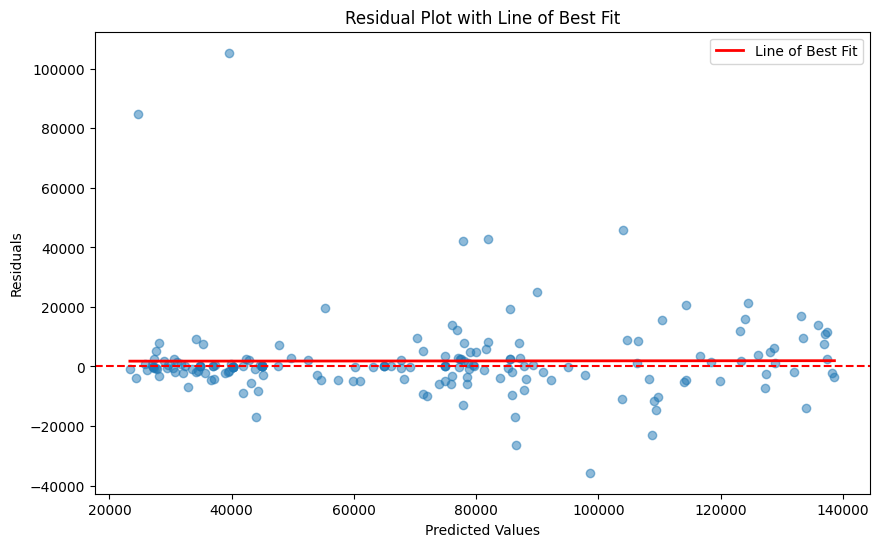

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Your existing code, assuming y_test and y_pred are defined

# New: Initialize a list to store residuals for all segments
all_residuals = []
all_predicted = []

for lower, upper in price_categories:
    mask = (y_test >= lower) & (y_test < upper)
    y_test_segment = y_test[mask]
    y_pred_segment = y_pred[mask]

    if len(y_test_segment) > 0:
        mse_segment = mean_squared_error(y_test_segment, y_pred_segment)
        mae_segment = mean_absolute_error(y_test_segment, y_pred_segment)

        print(f"Price Range {lower}-{upper if upper != np.inf else '1M+'}:")
        print(f"  MSE: {mse_segment}")
        print(f"  MAE: {mae_segment}")

        # New: Calculate residuals for the current segment and store them
        residuals_segment = y_test_segment - y_pred_segment
        all_residuals.extend(residuals_segment)
        all_predicted.extend(y_pred_segment)
    else:
        print(f"Price Range {lower}-{upper if upper != np.inf else '1M+'}: No data available")


# Calculate coefficients for the line of best fit
slope, intercept = np.polyfit(all_predicted, all_residuals, 1)

# Generate x values from your predicted values range for plotting the line of best fit
line_x = np.linspace(min(all_predicted), max(all_predicted), 100)

# Calculate corresponding y values using the line equation y = mx + b
line_y = slope * line_x + intercept

# Calculate the standard deviation of the residuals
std_residuals = np.std(all_residuals)

# Plotting the residuals as before
plt.figure(figsize=(10, 6))
plt.scatter(all_predicted, all_residuals, alpha=0.5)

# Plot the line of best fit
plt.plot(line_x, line_y, 'r-', linewidth=2, label='Line of Best Fit')

# Add a shaded area around the line of best fit for the standard deviation
plt.fill_between(line_x, line_y - std_residuals, line_y + std_residuals, color='r', alpha=0.2, label='Standard Deviation')

plt.title('Residual Plot with Line of Best Fit and Standard Deviation')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()


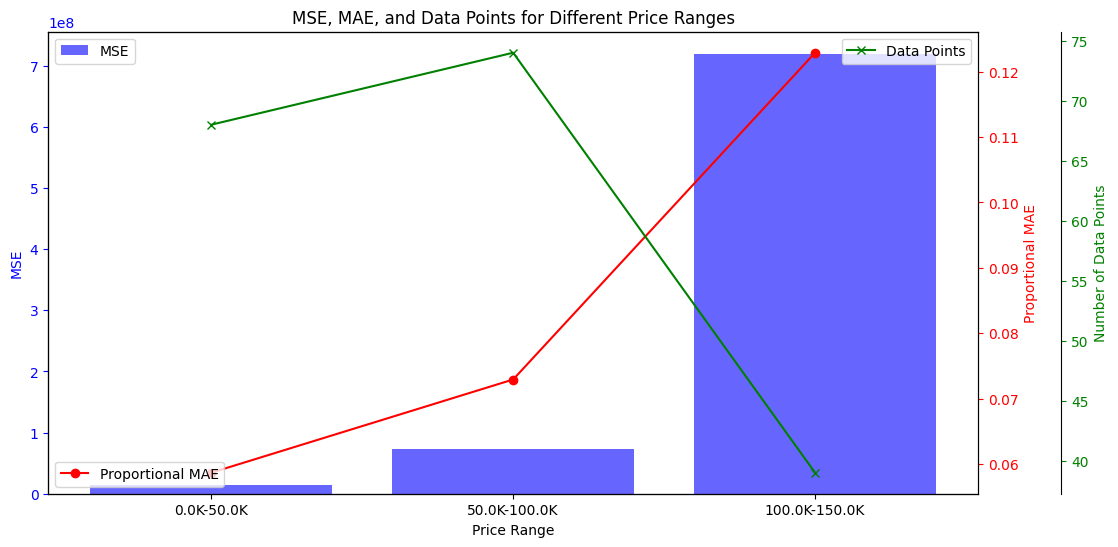

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_test and y_pred as your actual and predicted values

# Define your price ranges
# price_categories = [(0, 100000), (100000, 200000), (200000, 300000), 
#                     (300000, 400000), (500000, 600000), (600000, 700000)]
price_categories = [(0, 50000), (50000, 100000), (100000, 150000), 
                     (150000, 200000), (2000000, 250000), (250000, 300000)]

# Initialize lists to store metrics and evidence count
mse_values = []
mae_values = []
mae_proportional_values = []
evidence_counts = []
price_range_labels = []

for lower, upper in price_categories:
    mask = (y_test >= lower) & (y_test < upper)
    y_test_segment = y_test[mask]
    y_pred_segment = y_pred[mask]

    if len(y_test_segment) > 0:
        # Calculate MSE and MAE for this segment
        mse_values.append(mean_squared_error(y_test_segment, y_pred_segment))
        # mae_values.append(mean_absolute_error(y_test_segment, y_pred_segment))
        mae_value = mean_absolute_error(y_test_segment, y_pred_segment)
        mean_price = np.mean(y_test_segment)
        mae_proportional = mae_value / mean_price  # Proportional MAE
        mae_proportional_values.append(mae_proportional)
        evidence_counts.append(len(y_test_segment))
        price_range_labels.append(f"{lower/1000}K-{upper/1000}K")

# Create subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting MSE
ax1.bar(price_range_labels, mse_values, color='b', alpha=0.6, label='MSE')
ax1.set_xlabel('Price Range')
ax1.set_ylabel('MSE', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for MAE
ax2 = ax1.twinx()
# ax2.plot(price_range_labels, mae_values, color='r', marker='o', label='MAE')
ax2.plot(price_range_labels, mae_proportional_values, color='r', marker='o', label='Proportional MAE')

# ax2.set_ylabel('MAE', color='r')
ax2.set_ylabel('Proportional MAE', color='r')

ax2.tick_params('y', colors='r')

# Creating a third y-axis for Evidence Count
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
ax3.plot(price_range_labels, evidence_counts, color='g', marker='x', label='Data Points')
ax3.set_ylabel('Number of Data Points', color='g')
ax3.tick_params('y', colors='g')

# Title and legends
plt.title('MSE, MAE, and Data Points for Different Price Ranges')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
ax3.legend(loc='upper right')

# Show plot
# plt.show()


In [19]:
# Aston_Martin - Extended Data

import pandas as pd
import numpy as np
import joblib

# Load the saved model, vectorizer, and preprocessor
model = joblib.load('car_price_prediction_model_aston_martin.joblib')
vectorizer = joblib.load('tfidf_vectorizer_aston_martin.joblib')
preprocessor = joblib.load('preprocessor_aston_martin.joblib')

# Example new data for prediction
new_data = [
    {'Make': 'Aston Martin Vanquish', 'Model': '6.0 V12 Coupe 2dr Petrol T-TronicII Euro 5 (565 bhp)', 'Mileage': 33000, 'Year': 2013, 'Prior_Owners': '4', 'Car_Type': 'coupe', 'Sale_Type': 'Private seller'}
    # Add more cars as needed
]

# Convert to DataFrame
new_data_df = pd.DataFrame(new_data)

# Apply the preprocessing pipeline to the new data
X_new_tfidf = vectorizer.transform(new_data_df['Model'])
X_new_preprocessed = preprocessor.transform(new_data_df.drop('Model', axis=1))

# Convert to dense array if sparse
if hasattr(X_new_preprocessed, "toarray"):
    X_new_preprocessed = X_new_preprocessed.toarray()

# Combine TF-IDF features with preprocessed numeric and categorical features
X_new_combined = np.hstack((X_new_tfidf.toarray(), X_new_preprocessed))

# Make predictions
predicted_prices = model.predict(X_new_combined)

# Output predicted prices
for i, car in enumerate(new_data):
    print(f"Car: {car['Make']}, Predicted Price: £{predicted_prices[i]:.2f}")

Car: Aston Martin Vanquish, Predicted Price: £70975.23


In [20]:
import pandas as pd
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Load the saved model, vectorizer, and preprocessor
model = joblib.load('car_price_prediction_model_aston_martin.joblib')
vectorizer = joblib.load('tfidf_vectorizer_aston_martin.joblib')
preprocessor = joblib.load('preprocessor_aston_martin.joblib')

# Load the cleaned dataset
data = pd.read_csv('filtered_cleaned_auto_trader_data_aston_martin.csv')

# Define preprocessing steps
numeric_features = ['Mileage', 'Year', 'Prior_Owners']
categorical_features = ['Make', 'Car_Type', 'Sale_Type']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) #! this feels bad we don't want "missing" appearing in dataset, unless "missing" could actual devalue a car in dealers eyes in reality?

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess numeric and categorical features
X_preprocessed = preprocessor.fit_transform(data)

# Preprocess text feature 'Model'
X_text = vectorizer.transform(data['Model'].fillna(''))

# Convert to dense array if sparse
if hasattr(X_preprocessed, "toarray"):
    X_preprocessed = X_preprocessed.toarray()
if hasattr(X_text, "toarray"):
    X_text = X_text.toarray()

# Combine the processed features
X_combined = np.hstack((X_preprocessed, X_text))

# Predict prices with the model
predicted_prices = model.predict(X_combined)

# Add the predicted prices to the DataFrame
data['Predicted_Price'] = predicted_prices

# Calculate the percentage difference between predicted and actual prices
data['Price_Diff_Percent'] = ((data['Predicted_Price'] - data['Price']) / data['Price']) * 100

# Filter to find potential undervalued cars with 10-35% price difference # TODO investigate the results in different brackets. Also investigate the distribution of these predictions (are there any outliers)
undervalued_cars = data[(data['Price_Diff_Percent'] > 10) & (data['Price_Diff_Percent'] < 35)]

# Sort the undervalued cars by Make and Location
sorted_undervalued_cars = undervalued_cars.sort_values(['Make', 'Dealership_Location'])

# Print out the sorted undervalued cars with 10-35% price difference, including Title_URL
print(sorted_undervalued_cars[['Make', 'Model', 'Dealership_Location', 'Price', 'Predicted_Price', 'Price_Diff_Percent', 'Title_URL', 'Sale_Type']])

sorted_undervalued_cars.to_csv('filtered_sorted_undervalued_cars.csv', index=False)


                     Make                                              Model  \
9     Aston Martin Cygnet              1.3 VVT Launch Edition CVT Euro 5 3dr   
482      Aston Martin DB7                                    5.9 Vantage 2dr   
665      Aston Martin DB7                                            3.2 2dr   
478      Aston Martin DB7  5.9 V12 Vantage Coupe 2dr Petrol (450 g/km, 42...   
593      Aston Martin DB7                                    5.9 Volante 2dr   
..                    ...                                                ...   
348  Aston Martin Vantage                                  4.3 V8 Euro 4 2dr   
362  Aston Martin Vantage                                  4.3 V8 Euro 4 2dr   
417  Aston Martin Vantage                       4.7 V8 Sportshift Euro 4 2dr   
663  Aston Martin Vantage                         4.3 V8 Roadster Euro 4 2dr   
706  Aston Martin Vantage                       4.7 V8 Sportshift Euro 4 2dr   

            Dealership_Location    Pric

In [21]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the cleaned dataset, model, vectorizer, and preprocessor
data = pd.read_csv('filtered_auto_trader_data_aston_martin.csv')
model = joblib.load('car_price_prediction_model_aston_martin.joblib')
vectorizer = joblib.load('tfidf_vectorizer_aston_martin.joblib')
preprocessor = joblib.load('preprocessor_aston_martin.joblib')

# Define the target car details
target_car = {
    'Make': 'Aston Martin', 
    'Model': 'Vantage 4.3 V8 Sportshift Euro 4 2dr', 
    'Mileage': 19000, 
    'Year': 2008, 
    'Prior_Owners': 1, 
    'Car_Type': 'Coupe', 
    'Sale_Type': 'Private seller'
}

# Convert the target car data into a DataFrame
target_car_df = pd.DataFrame([target_car], columns=[key for key in target_car.keys()])

# Process target car info for TF-IDF vectorization
target_car_df['Combined_Info'] = target_car_df['Make'] + " " + target_car_df['Model']
X_target_tfidf = vectorizer.transform(target_car_df['Combined_Info'])

# Drop the 'Make' and 'Model' columns if they were not used as raw features during training
# # Ensure other necessary columns are present
# target_car_df = target_car_df.drop(['Make', 'Model', 'Combined_Info'], axis=1)

# Transform the rest of the features using the preprocessor
X_target_preprocessed = preprocessor.transform(target_car_df)

# Combine TF-IDF features with preprocessed numeric and categorical features
X_target_combined = np.hstack((X_target_tfidf.toarray(), X_target_preprocessed.toarray()))

# Predict the price of the target car
predicted_price = model.predict(X_target_combined)
print(f"Predicted price of the entered car: {predicted_price[0]}")

similar_scores = []
for data in X_target_preprocessed:
    # Compute similarity scores
    similar_scores.append(cosine_similarity(data, X_target_tfidf))

print(similar_scores)
# Add similarity scores to the dataframe
data['Similarity'] = similar_scores.flatten()

# Sort the dataframe based on similarity
similar_cars = data.sort_values(by='Similarity', ascending=False)

# Display the top similar cars
print("Top similar cars:")
print(similar_cars[['Make', 'Model', 'Year', 'Price', 'Mileage', 'Car_Type', 'Sale_Type', 'Similarity']].head())

# Save the similar cars to an Excel file
similar_cars.to_excel('similar_cars.xlsx', index=False)




FileNotFoundError: [Errno 2] No such file or directory: 'filtered_auto_trader_data_aston_martin.csv'